In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor  # 使用梯度提升回归器
from scipy.stats import randint, uniform

In [2]:
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
from numpy.random import seed 
seed(200)

In [4]:
data = pd.read_excel('data/CO2_20250208.xlsx', sheet_name='CO2 solubility data')

In [5]:
data.head(8)

,No.,IL,x_CO2 (mol/kg sorbent),T (K),P (bar),IF1,IF2,IF3,IF4,IF5,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
0,1,[Bis(mim)C2][Gly]2,0.8504,313.15,0.1154,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,[Bis(mim)C2][Gly]2,1.1442,313.15,0.2692,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,[Bis(mim)C2][Gly]2,1.4535,313.15,0.5385,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,[Bis(mim)C2][Gly]2,2.3503,313.15,0.8462,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,[Bis(mim)C2][Gly]2,2.4895,313.15,1.3077,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,[Bis(mim)C2][Gly]2,2.5823,313.15,1.7308,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,[Bis(mim)C2][Gly]2,2.6132,313.15,2.0000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,[Bis(mim)C2][Gly]2,2.6441,313.15,2.9615,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(data.shape)

(2500, 49)


In [7]:
exclude =['No.','IL']
y='x_CO2 (mol/kg sorbent)'
features = [var for var in data.columns if var not in exclude+[y]]
print(len(features), len(exclude))

46 2


In [8]:
data[features].info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 46 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   T (K)    2500 non-null   float64
 1   P (bar)  2500 non-null   float64
 2   IF1      2500 non-null   int64  
 3   IF2      2500 non-null   int64  
 4   IF3      2500 non-null   int64  
 5   IF4      2500 non-null   int64  
 6   IF5      2500 non-null   int64  
 7   IF6      2500 non-null   int64  
 8   IF7      2500 non-null   int64  
 9   IF8      2500 non-null   int64  
 10  IF9      2500 non-null   int64  
 11  IF10     2500 non-null   int64  
 12  IF11     2500 non-null   int64  
 13  IF12     2500 non-null   int64  
 14  IF13     2500 non-null   int64  
 15  IF14     2500 non-null   int64  
 16  IF15     2500 non-null   int64  
 17  IF16     2500 non-null   int64  
 18  IF17     2500 non-null   int64  
 19  IF18     2500 non-null   int64  
 20  IF19     2500 non-null   int64  
 21  IF20     2500 

In [9]:
single_var =[]
for var in features:
    print(var, "----",len(data[var].unique()),data[var].unique())
    if len(data[var].unique())==1:
        single_var.append(var)

T (K) ---- 48 [313.15 293.15 303.15 323.15 298.2  298.1  298.   298.3  288.15 298.15
 308.15 318.15 303.16 313.28 313.31 323.32 323.34 333.35 333.36 333.41
 353.55 353.18 295.15 283.1  323.1  348.1  348.2  310.15 333.15 343.15
 303.2  313.2  323.2  343.2  353.2  328.15 338.15 333.2  295.12 353.15
 296.15 373.15 393.15 308.   318.   328.   338.   283.15]
P (bar) ---- 1112 [0.1154 0.2692 0.5385 ... 0.234  0.239  0.419 ]
IF1 ---- 4 [ 2  1  0 10]
IF2 ---- 2 [0 1]
IF3 ---- 3 [0 2 1]
IF4 ---- 2 [0 1]
IF5 ---- 2 [0 1]
IF6 ---- 5 [ 0  1  2  3 10]
IF7 ---- 2 [0 1]
IF8 ---- 2 [0 1]
IF9 ---- 2 [0 1]
IF10 ---- 4 [0 3 2 1]
IF11 ---- 2 [0 1]
IF12 ---- 3 [0 2 1]
IF13 ---- 3 [0 1 2]
IF14 ---- 2 [0 1]
IF15 ---- 11 [ 2  4  5  3 20  1  6  8 12  7 40]
IF16 ---- 32 [  4   2   6   3   5   7   8   1  25  11  14   0  10  31  29  30  32  20
  26  21  12  24  22  33  17  13  16  28 295  58  57  56]
IF17 ---- 3 [0 1 2]
IF18 ---- 2 [0 1]
IF19 ---- 2 [0 1]
IF20 ---- 3 [0 2 1]
IF21 ---- 2 [0 1]
IF22 ---- 14 [ 6 12 

In [10]:
single_var

[]

In [11]:
# 确保只使用数值特征
use_features = [var for var in features if data[var].dtype in ['int64', 'float64']]

print(f"使用的特征数量: {len(use_features)}")
print(f"特征列表: {use_features}")

使用的特征数量: 46
特征列表: ['T (K)', 'P (bar)', 'IF1', 'IF2', 'IF3', 'IF4', 'IF5', 'IF6', 'IF7', 'IF8', 'IF9', 'IF10', 'IF11', 'IF12', 'IF13', 'IF14', 'IF15', 'IF16', 'IF17', 'IF18', 'IF19', 'IF20', 'IF21', 'IF22', 'IF23', 'IF24', 'IF25', 'IF26', 'IF27', 'IF28', 'IF29', 'IF30', 'IF31', 'IF32', 'IF33', 'IF34', 'IF35', 'IF36', 'IF37', 'IF38', 'IF39', 'IF40', 'IF41', 'IF42', 'IF43', 'IF44']


In [12]:
# 分割数据
X_train, X_test, y_train, y_test = train_test_split(
    data[use_features], data[y], test_size=0.2, random_state=512
)

print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")

训练集形状: (2000, 46), 测试集形状: (500, 46)


In [13]:
# 标准化
sc = StandardScaler()
sc.fit(X_train[use_features])

StandardScaler()

In [14]:
sc.mean_

array([3.10632380e+02, 1.83707045e+00, 4.51000000e-01, 5.00000000e-04,
       1.34500000e-01, 4.30000000e-02, 1.72500000e-01, 4.72000000e-01,
       2.15000000e-02, 9.00000000e-03, 9.00000000e-03, 4.50000000e-03,
       2.00000000e-03, 1.21000000e-01, 3.90000000e-02, 6.15000000e-02,
       3.44700000e+00, 1.29545000e+01, 3.31000000e-01, 4.00000000e-03,
       1.19000000e-01, 1.20000000e-01, 1.65000000e-02, 3.68900000e+00,
       8.30000000e-01, 1.65000000e-01, 4.60000000e-02, 1.65000000e-02,
       1.42000000e-01, 1.85000000e-02, 5.05500000e-01, 7.14000000e-01,
       6.55000000e-02, 5.85000000e-02, 5.15000000e-02, 9.80000000e-02,
       2.70000000e-02, 1.00000000e-03, 6.30000000e-02, 3.65000000e-02,
       1.65000000e-02, 6.00000000e-03, 3.35000000e-02, 1.00000000e-02,
       5.00000000e-04, 1.00000000e-03])

In [15]:
# 转换数据
X_train_scale = sc.transform(X_train[use_features])
X_test_scale = sc.transform(X_test[use_features])

In [16]:
X_train[use_features].head(1)

,T (K),P (bar),IF1,IF2,IF3,IF4,IF5,IF6,IF7,IF8,...,IF35,IF36,IF37,IF38,IF39,IF40,IF41,IF42,IF43,IF44
268,288.15,3.5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_train_scale[0:1]

array([[-1.25694529,  0.55835751,  0.86416626, -0.02236627, -0.32774696,
        -0.21197188, -0.45657334, -0.59221756, -0.14823092, -0.09529814,
        -0.09529814, -0.0488676 , -0.04476615, -0.30122345, -0.16708984,
        -0.25598848, -0.54581662, -0.43457622, -0.58748645, -0.06337243,
        -0.36752385, -0.36753834, -0.12952535, -0.19788331,  0.1258362 ,
        -0.34725301, -0.1627526 , -0.12952535, -0.30565141, -0.13729057,
         0.74892464,  0.3242047 , -0.26474697, -0.21789901, -0.23301557,
        -0.29231469, -0.166581  , -0.0316386 , -0.25929878, -0.19463484,
        -0.12952535, -0.0776931 , -0.18617505, -0.10050378, -0.02236627,
        -0.0316386 ]])

In [18]:
import time

In [19]:
# 方法1：使用早停法的GBR
gbr = GradientBoostingRegressor(
    n_estimators=1000,           # 设置大量树
    validation_fraction=0.1,     # 验证集比例
    n_iter_no_change=10,         # 早停条件
    tol=1e-4,                    # 容忍度
    random_state=256
)


In [20]:
# 严格的参数分布
param_distributions = {
    'learning_rate': uniform(0.05, 0.15),        # 0.05-0.15
    'max_depth': randint(3, 6),                 # 2-4
    'subsample': uniform(0.7, 0.3),             # 0.6-0.9
    'max_features': uniform(0.7, 0.3),          # 0.5-0.9
    'min_samples_split': randint(10, 20),       # 10-24
    'min_samples_leaf': randint(3, 10),         # 5-14
}


In [21]:
# 使用标准评分
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_distributions,
    n_iter=50,                  # 减少迭代次数
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=256,
    return_train_score=True     # 返回训练分数用于后续分析
)

In [22]:
# 开始优化
print("开始随机搜索优化...")
random_search.fit(X_train[use_features], y_train)
print("随机搜索完成！")

# 分析结果，选择不过拟合的模型
results_df = pd.DataFrame(random_search.cv_results_)

# 计算过拟合比率（越小越好）
results_df['overfitting_ratio'] = (-results_df['mean_train_score']) / (-results_df['mean_test_score'])

# 选择过拟合程度低且性能好的模型
# 优先选择 overfitting_ratio < 1.2 的模型
filtered_results = results_df[results_df['overfitting_ratio'] < 1.2]

if len(filtered_results) > 0:
    best_idx = filtered_results['mean_test_score'].idxmax()
else:
    # 如果没有找到低过拟合的模型，选择过拟合比率最小的
    best_idx = results_df['overfitting_ratio'].idxmin()

best_params = results_df.loc[best_idx, 'params']
best_score = results_df.loc[best_idx, 'mean_test_score']

print(f"\n最佳参数: {best_params}")
print(f"最佳测试分数: {-best_score:.6f}")
print(f"过拟合比率: {results_df.loc[best_idx, 'overfitting_ratio']:.6f}")

开始随机搜索优化...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
随机搜索完成！

最佳参数: {'learning_rate': 0.1197248639483835, 'max_depth': 5, 'max_features': 0.837157989396516, 'min_samples_leaf': 3, 'min_samples_split': 15, 'subsample': 0.8511580920506898}
最佳测试分数: 0.148889
过拟合比率: 0.272492


In [23]:
# 获取最佳模型
best_gbr = random_search.best_estimator_
print(f"最佳参数组合: {best_gbr}")

最佳参数组合: GradientBoostingRegressor(learning_rate=0.1197248639483835, max_depth=5,
                          max_features=0.837157989396516, min_samples_leaf=3,
                          min_samples_split=15, n_estimators=1000,
                          n_iter_no_change=10, random_state=256,
                          subsample=0.8511580920506898)


In [24]:
# 查看实际使用的树数量
actual_trees = len(best_gbr.estimators_)
print(f"实际训练的树数量: {actual_trees}")
print(f"设置的树数量: {best_gbr.n_estimators}")

# 查看训练过程
train_score = best_gbr.train_score_  # 训练过程中的分数
print(f"训练过程长度: {len(train_score)}")

实际训练的树数量: 208
设置的树数量: 1000
训练过程长度: 208


In [25]:
print("最优模型分数（负均方误差）:", random_search.best_score_)

最优模型分数（负均方误差）: -0.14888943760027756


In [26]:
def comprehensive_model_evaluation(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    全面评估模型在训练集和测试集上的性能
    """
    # 预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算各项指标
    def calculate_metrics(y_true, y_pred):
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        
        # 稳健的AARD计算（避免除零错误）
        with np.errstate(divide='ignore', invalid='ignore'):
            relative_errors = np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-10, None))
            aard = 100 * np.nanmean(relative_errors)
        
        return {
            'R2': r2, 
            'MAE': mae, 
            'MSE': mse, 
            'RMSE': rmse, 
            'AARD%': aard
        }
    
    # 计算训练集和测试集指标
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # 计算过拟合程度
    overfitting_gap = {
        'R2_gap': train_metrics['R2'] - test_metrics['R2'],
        'MSE_ratio': train_metrics['MSE'] / test_metrics['MSE'],
        'AARD_increase': test_metrics['AARD%'] - train_metrics['AARD%']
    }
    
    # 输出结果
    print("="*80)
    print(f"{model_name} 性能综合评估")
    print("="*80)
    
    # 详细指标表格
    print(f"{'Metric':<12} {'Training':<15} {'Test':<15} {'Difference':<15} {'Unit':<10}")
    print("-" * 70)
    for metric in ['R2', 'MAE', 'MSE', 'RMSE', 'AARD%']:
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        
        if metric == 'R2':
            diff = train_val - test_val  # R²差距（越小越好）
            unit = ''
        elif metric == 'AARD%':
            diff = test_val - train_val  # AARD增加量（越小越好）
            unit = '%'
        else:
            diff = test_val - train_val  # 误差增加量（越小越好）
            unit = ''
        
        print(f"{metric:<12} {train_val:<15.6f} {test_val:<15.6f} {diff:<15.6f} {unit:<10}")
    
    # 过拟合分析
    print("-" * 70)
    print("过拟合分析:")
    print(f"R²差距: {overfitting_gap['R2_gap']:.6f} (越小越好，<0.1为佳)")
    print(f"MSE比率: {overfitting_gap['MSE_ratio']:.6f} (越接近1越好)")
    print(f"AARD增加: {overfitting_gap['AARD_increase']:.6f}% (越小越好)")
    
    print("="*80)
    
    return {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'overfitting_analysis': overfitting_gap,
        'predictions': {
            'y_train_pred': y_train_pred,
            'y_test_pred': y_test_pred
        }
    }

# 使用最优模型进行评估
best_model = random_search.best_estimator_
results = comprehensive_model_evaluation(
    best_model, 
    X_train[use_features], y_train,
    X_test[use_features], y_test,
    "GBR Optimal Model"
)

GBR Optimal Model 性能综合评估
Metric       Training        Test            Difference      Unit      
----------------------------------------------------------------------
R2           0.963670        0.883593        0.080077                  
MAE          0.145616        0.228920        0.083304                  
MSE          0.053166        0.160543        0.107377                  
RMSE         0.230577        0.400679        0.170101                  
AARD%        37.351287       33.776980       -3.574307       %         
----------------------------------------------------------------------
过拟合分析:
R²差距: 0.080077 (越小越好，<0.1为佳)
MSE比率: 0.331163 (越接近1越好)
AARD增加: -3.574307% (越小越好)


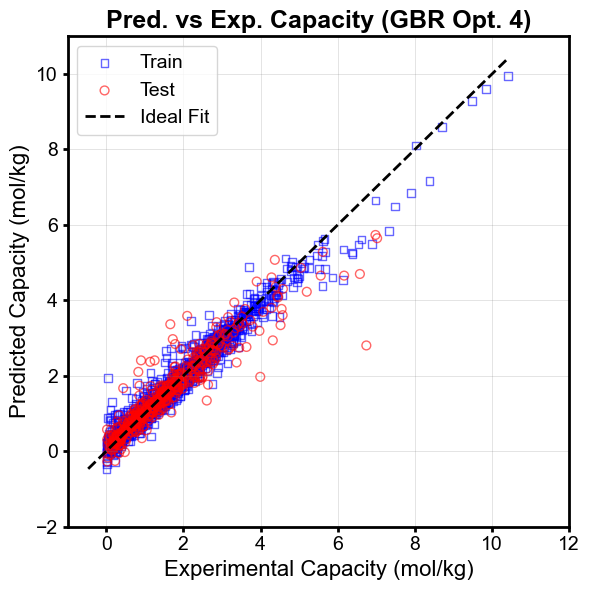

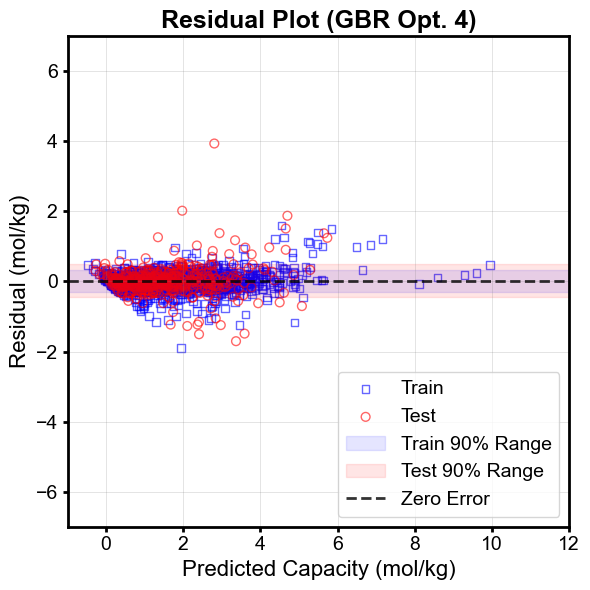

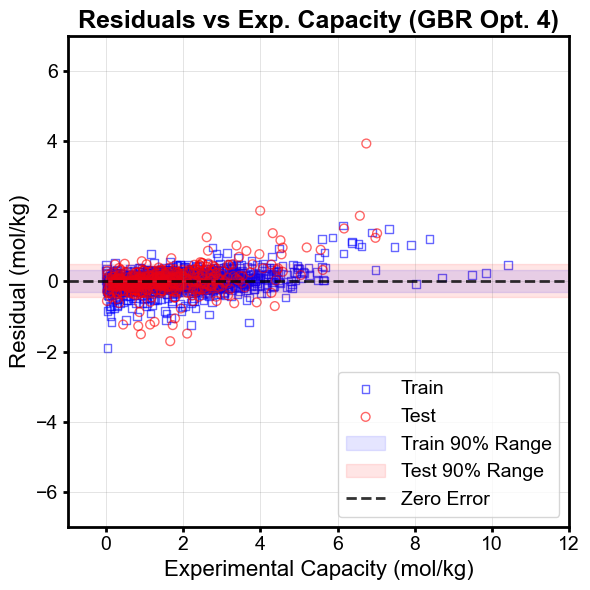

GBR Opt. 4 90% 数据点残差范围分析 - 残差 vs 预测值图
训练集: 90.0% 的数据点残差在 [-0.3062, 0.3210] mol/kg 范围内
测试集: 90.0% 的数据点残差在 [-0.4367, 0.4940] mol/kg 范围内

📊 数值含义:
1. 范围区间表示90%的数据点的预测误差大小
2. 负值表示模型高估真实值，正值表示模型低估真实值
3. 区间越窄，说明模型预测越精确
4. 区间包含0，说明预测基本无偏
5. 训练集范围: ±0.3210 mol/kg
6. 测试集范围: ±0.4940 mol/kg

GBR Opt. 4 90% 数据点残差范围分析 - 残差 vs 实验值图
训练集: 90.0% 的数据点残差在 [-0.3062, 0.3210] mol/kg 范围内
测试集: 90.0% 的数据点残差在 [-0.4367, 0.4940] mol/kg 范围内

GBR Opt. 4 详细统计信息
训练集 R²: 0.9637
测试集 R²: 0.8836
训练集 MAE: 0.1456 mol/kg
测试集 MAE: 0.2289 mol/kg
训练集 RMSE: 0.2306 mol/kg
测试集 RMSE: 0.4007 mol/kg
训练集残差均值: -0.0027 mol/kg
测试集残差均值: 0.0230 mol/kg
训练集残差标准差: 0.2306 mol/kg
测试集残差标准差: 0.4004 mol/kg

GBR Opt. 4 模型性能评估
❌ 需要改进: 预测误差较大
过拟合程度: 0.1730 mol/kg
训练集 AARD%: 37.35%
测试集 AARD%: 33.78%


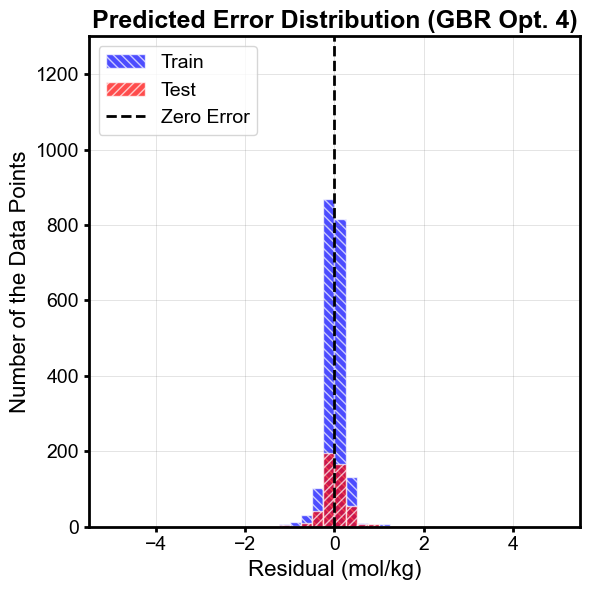

GBR Opt. 4 误差区间统计信息

训练集误差分布:
  [-2.000, -1.750]: 1个数据点 (0.1%)
  [-1.250, -1.000]: 6个数据点 (0.3%)
  [-1.000, -0.750]: 12个数据点 (0.6%)
  [-0.750, -0.500]: 31个数据点 (1.6%)
  [-0.500, -0.250]: 103个数据点 (5.1%)
  [-0.250, 0.000]: 868个数据点 (43.4%)
  [0.000, 0.250]: 816个数据点 (40.8%)
  [0.250, 0.500]: 133个数据点 (6.7%)
  [0.500, 0.750]: 11个数据点 (0.5%)
  [0.750, 1.000]: 8个数据点 (0.4%)
  [1.000, 1.250]: 7个数据点 (0.4%)
  [1.250, 1.500]: 3个数据点 (0.1%)
  [1.500, 1.750]: 1个数据点 (0.1%)

测试集误差分布:
  [-1.750, -1.500]: 2个数据点 (0.4%)
  [-1.500, -1.250]: 2个数据点 (0.4%)
  [-1.250, -1.000]: 5个数据点 (1.0%)
  [-1.000, -0.750]: 2个数据点 (0.4%)
  [-0.750, -0.500]: 9个数据点 (1.8%)
  [-0.500, -0.250]: 41个数据点 (8.2%)
  [-0.250, 0.000]: 195个数据点 (39.0%)
  [0.000, 0.250]: 165个数据点 (33.0%)
  [0.250, 0.500]: 54个数据点 (10.8%)
  [0.500, 0.750]: 8个数据点 (1.6%)
  [0.750, 1.000]: 7个数据点 (1.4%)
  [1.000, 1.250]: 3个数据点 (0.6%)
  [1.250, 1.500]: 3个数据点 (0.6%)
  [1.500, 1.750]: 1个数据点 (0.2%)
  [1.750, 2.000]: 1个数据点 (0.2%)
  [2.000, 2.250]: 1个数据点 (0.2%)
  [3.750, 4.000

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 设置全局字体为Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

# 获取预测值
train_y_pred = results['predictions']['y_train_pred']
test_y_pred = results['predictions']['y_test_pred']

# 1. 预测值与真实值对比图 - GBR Opt. 2
plt.figure(figsize=(6, 6))

# 绘制训练集和测试集在同一张图上
plt.scatter(y_train, train_y_pred, color='none', edgecolor='blue', 
           alpha=0.6, s=30, label="Train", linewidth=1, marker='s')
plt.scatter(y_test, test_y_pred, color='none', edgecolor='red', 
           alpha=0.6, s=40, label="Test", linewidth=1, marker='o')

# 绘制理想拟合线
min_val = min(min(y_train), min(y_test), min(train_y_pred), min(test_y_pred))
max_val = max(max(y_train), max(y_test), max(train_y_pred), max(test_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='black', 
         linestyle='--', linewidth=2, label='Ideal Fit')

# 设置坐标轴范围
plt.ylim(-2, 11)
plt.xlim(-1, 12)

plt.xlabel("Experimental Capacity (mol/kg)", fontsize=16, fontname='Arial')
plt.ylabel("Predicted Capacity (mol/kg)", fontsize=16, fontname='Arial')
plt.title("Pred. vs Exp. Capacity (GBR Opt. 4)", fontsize=18, fontweight='bold', fontname='Arial')

# 设置图例
plt.legend(loc='upper left', prop={'family': 'Arial', 'size': 14})

# 设置刻度标签
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

# 设置刻度线
plt.tick_params(axis='both', which='major', width=2, color='black')

# 设置外框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 2. 残差 vs 预测值图 - GBR Opt. 2
plt.figure(figsize=(6, 6))

# 计算误差
train_errors = y_train - train_y_pred
test_errors = y_test - test_y_pred

# 计算90%数据点的残差范围函数
def calculate_90_percent_range(errors):
    """计算90%数据点落入的残差范围"""
    lower_bound = np.percentile(errors, 5)
    upper_bound = np.percentile(errors, 95)
    in_range = np.sum((errors >= lower_bound) & (errors <= upper_bound))
    total = len(errors)
    percentage = (in_range / total) * 100
    return lower_bound, upper_bound, percentage

# 计算训练集和测试集的90%范围
train_lower, train_upper, train_percentage = calculate_90_percent_range(train_errors)
test_lower, test_upper, test_percentage = calculate_90_percent_range(test_errors)

# 绘制残差图
plt.scatter(train_y_pred, train_errors, alpha=0.6, s=30, color='none', 
            edgecolor='blue', linewidth=1, label='Train', marker='s')
plt.scatter(test_y_pred, test_errors, alpha=0.6, s=40, color='none', 
            edgecolor='red', linewidth=1, label='Test', marker='o')

# 标记90%范围
plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')

# 设置坐标轴范围
plt.ylim(-7, 7)
plt.xlim(-1, 12)

plt.xlabel('Predicted Capacity (mol/kg)', fontsize=16, fontname='Arial')
plt.ylabel('Residual (mol/kg)', fontsize=16, fontname='Arial')
plt.title('Residual Plot (GBR Opt. 4)', fontsize=18, fontweight='bold', fontname='Arial')

# 设置图例
plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 14})

# 设置刻度标签
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

# 设置刻度和边框
plt.tick_params(axis='both', which='major', width=2, color='black')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 3. 残差 vs 实验值图 - GBR Opt. 2
plt.figure(figsize=(6, 6))

# 绘制残差图（横坐标改为实验值）
plt.scatter(y_train, train_errors, alpha=0.6, s=30, color='none', 
            edgecolor='blue', linewidth=1, label='Train', marker='s')
plt.scatter(y_test, test_errors, alpha=0.6, s=40, color='none', 
            edgecolor='red', linewidth=1, label='Test', marker='o')

# 标记90%范围
plt.axhspan(train_lower, train_upper, alpha=0.1, color='blue', label='Train 90% Range')
plt.axhspan(test_lower, test_upper, alpha=0.1, color='red', label='Test 90% Range')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, label='Zero Error')

# 设置坐标轴范围
plt.ylim(-7, 7)
plt.xlim(-1, 12)

plt.xlabel('Experimental Capacity (mol/kg)', fontsize=16, fontname='Arial')
plt.ylabel('Residual (mol/kg)', fontsize=16, fontname='Arial')
plt.title('Residuals vs Exp. Capacity (GBR Opt. 4)', fontsize=18, fontweight='bold', fontname='Arial')

# 设置图例
plt.legend(loc='lower right', prop={'family': 'Arial', 'size': 14})

# 设置刻度标签
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

# 设置刻度和边框
plt.tick_params(axis='both', which='major', width=2, color='black')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()



# 计算并打印预测值vs残差图的90%范围和解释
print("="*80)
print("GBR Opt. 4 90% 数据点残差范围分析 - 残差 vs 预测值图")
print("="*80)
print(f"训练集: {train_percentage:.1f}% 的数据点残差在 [{train_lower:.4f}, {train_upper:.4f}] mol/kg 范围内")
print(f"测试集: {test_percentage:.1f}% 的数据点残差在 [{test_lower:.4f}, {test_upper:.4f}] mol/kg 范围内")

print("\n📊 数值含义:")
print("1. 范围区间表示90%的数据点的预测误差大小")
print("2. 负值表示模型高估真实值，正值表示模型低估真实值")
print("3. 区间越窄，说明模型预测越精确")
print("4. 区间包含0，说明预测基本无偏")
print(f"5. 训练集范围: ±{max(abs(train_lower), abs(train_upper)):.4f} mol/kg")
print(f"6. 测试集范围: ±{max(abs(test_lower), abs(test_upper)):.4f} mol/kg")


# 计算并打印实验值vs残差图的90%范围
print("\n" + "="*80)
print("GBR Opt. 4 90% 数据点残差范围分析 - 残差 vs 实验值图")
print("="*80)
print(f"训练集: {train_percentage:.1f}% 的数据点残差在 [{train_lower:.4f}, {train_upper:.4f}] mol/kg 范围内")
print(f"测试集: {test_percentage:.1f}% 的数据点残差在 [{test_lower:.4f}, {test_upper:.4f}] mol/kg 范围内")


# 详细统计信息
print("\n" + "="*80)
print("GBR Opt. 4 详细统计信息")
print("="*80)
print(f"训练集 R²: {results['train_metrics']['R2']:.4f}")
print(f"测试集 R²: {results['test_metrics']['R2']:.4f}")
print(f"训练集 MAE: {results['train_metrics']['MAE']:.4f} mol/kg")
print(f"测试集 MAE: {results['test_metrics']['MAE']:.4f} mol/kg")
print(f"训练集 RMSE: {results['train_metrics']['RMSE']:.4f} mol/kg")
print(f"测试集 RMSE: {results['test_metrics']['RMSE']:.4f} mol/kg")
print(f"训练集残差均值: {train_errors.mean():.4f} mol/kg")
print(f"测试集残差均值: {test_errors.mean():.4f} mol/kg")
print(f"训练集残差标准差: {train_errors.std():.4f} mol/kg")
print(f"测试集残差标准差: {test_errors.std():.4f} mol/kg")

# 模型性能评估
print("\n" + "="*80)
print("GBR Opt. 4 模型性能评估")
print("="*80)
if max(abs(train_lower), abs(train_upper)) < 0.1 and max(abs(test_lower), abs(test_upper)) < 0.1:
    print("✅ 优秀: 90%预测误差 < 0.1 mol/kg")
elif max(abs(train_lower), abs(train_upper)) < 0.2 and max(abs(test_lower), abs(test_upper)) < 0.2:
    print("👍 良好: 90%预测误差 < 0.2 mol/kg")
elif max(abs(train_lower), abs(train_upper)) < 0.3 and max(abs(test_lower), abs(test_upper)) < 0.3:
    print("⚠️ 一般: 90%预测误差 < 0.3 mol/kg")
else:
    print("❌ 需要改进: 预测误差较大")

print(f"过拟合程度: {abs(max(abs(train_lower), abs(train_upper)) - max(abs(test_lower), abs(test_upper))):.4f} mol/kg")

# GBR特有指标（如果有）
if 'AARD%' in results['train_metrics']:
    print(f"训练集 AARD%: {results['train_metrics']['AARD%']:.2f}%")
    print(f"测试集 AARD%: {results['test_metrics']['AARD%']:.2f}%")



# 4. 误差分布图（按指定区间划分）- GBR Opt. 2
plt.figure(figsize=(6, 6))

# 按照指定的区间划分
bin_edges = []
current = 0
max_error = max(np.abs(train_errors.max()), np.abs(test_errors.max()))

# 生成区间边界
while current <= max_error + 0.25:
    bin_edges.extend([-current - 0.25, -current])
    if current != 0:
        bin_edges.extend([current, current + 0.25])
    current += 0.25

# 排序并去重
bin_edges = sorted(set(bin_edges))

# 绘制训练集和测试集误差分布
plt.hist(train_errors, bins=bin_edges, alpha=0.7, color='blue', 
         edgecolor='white', label='Train', density=False, hatch='\\\\\\\\')
plt.hist(test_errors, bins=bin_edges, alpha=0.7, color='red', 
         edgecolor='white', label='Test', density=False, hatch='////')
plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Error')

# 设置坐标轴范围
plt.ylim(0, 1300)
plt.xlim(-5.5, 5.5)

plt.xlabel('Residual (mol/kg)', fontsize=16, fontname='Arial')
plt.ylabel('Number of the Data Points', fontsize=16, fontname='Arial') 
plt.title('Predicted Error Distribution (GBR Opt. 4)', fontsize=18, fontweight='bold', fontname='Arial')

# 设置图例
plt.legend(loc='upper left', prop={'family': 'Arial', 'size': 14})

# 设置刻度标签
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

# 设置刻度和边框
plt.tick_params(axis='both', which='major', width=2, color='black')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

plt.grid(True, alpha=0.3, color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# 打印区间统计信息
print("="*60)
print("GBR Opt. 4 误差区间统计信息")
print("="*60)

def count_errors_in_ranges(errors, bin_edges, data_name):
    """统计每个区间的数据点数量"""
    counts, _ = np.histogram(errors, bins=bin_edges)
    print(f"\n{data_name}误差分布:")
    for i in range(len(bin_edges) - 1):
        lower = bin_edges[i]
        upper = bin_edges[i + 1]
        count = counts[i]
        if count > 0:
            print(f"  [{lower:.3f}, {upper:.3f}]: {count}个数据点 ({count/len(errors)*100:.1f}%)")

# 统计并打印
count_errors_in_ranges(train_errors, bin_edges, "训练集")
count_errors_in_ranges(test_errors, bin_edges, "测试集")

# 额外统计0.25范围内的数据比例
def count_in_025_range(errors):
    in_range = np.sum(np.abs(errors) <= 0.25)
    percentage = in_range / len(errors) * 100
    return in_range, percentage

train_in_range, train_percent = count_in_025_range(train_errors)
test_in_range, test_percent = count_in_025_range(test_errors)

print("\n" + "="*60)
print("GBR Opt. 4 ±0.25范围内的数据统计")
print("="*60)
print(f"训练集: {train_in_range}/{len(train_errors)} 个数据点在 ±0.25 范围内 ({train_percent:.1f}%)")
print(f"测试集: {test_in_range}/{len(test_errors)} 个数据点在 ±0.25 范围内 ({test_percent:.1f}%)")

# 添加模型性能比较
print("\n" + "="*60)
print("GBR Opt. 4 模型性能摘要")
print("="*60)
print(f"训练集 R²: {results['train_metrics']['R2']:.4f}")
print(f"测试集 R²: {results['test_metrics']['R2']:.4f}")
print(f"训练集 MAE: {results['train_metrics']['MAE']:.4f} mol/kg")
print(f"测试集 MAE: {results['test_metrics']['MAE']:.4f} mol/kg")
print(f"训练集 RMSE: {results['train_metrics']['RMSE']:.4f} mol/kg")
print(f"测试集 RMSE: {results['test_metrics']['RMSE']:.4f} mol/kg")


PREDICTION RESULTS FOR GBR OPT. 4 MODEL

GBR Opt. 4 预测结果统计:
训练集样本数: 2000
测试集样本数: 500
训练集平均绝对误差: 0.1456
测试集平均绝对误差: 0.2289
训练集R²: 0.9637
测试集R²: 0.8836

前20行预测结果:
         Model Dataset  True_y  Predicted_y  Absolute_Error  Relative_Error_%
0   GBR Opt. 4   Train  9.8530       9.6023          0.2507            2.5444
1   GBR Opt. 4   Train  1.9806       2.7268          0.7462           37.6732
2   GBR Opt. 4   Train  1.5088       1.5275          0.0187            1.2365
3   GBR Opt. 4   Train  0.2609       0.3879          0.1270           48.6887
4   GBR Opt. 4   Train  0.1360       0.2503          0.1143           84.0133
5   GBR Opt. 4   Train  1.8511       1.9042          0.0531            2.8666
6   GBR Opt. 4   Train  1.3384       1.3659          0.0275            2.0581
7   GBR Opt. 4   Train  2.4500       2.3492          0.1008            4.1125
8   GBR Opt. 4   Train  0.8730       0.9237          0.0507            5.8059
9   GBR Opt. 4   Train  3.8034       3.5877          0.2157

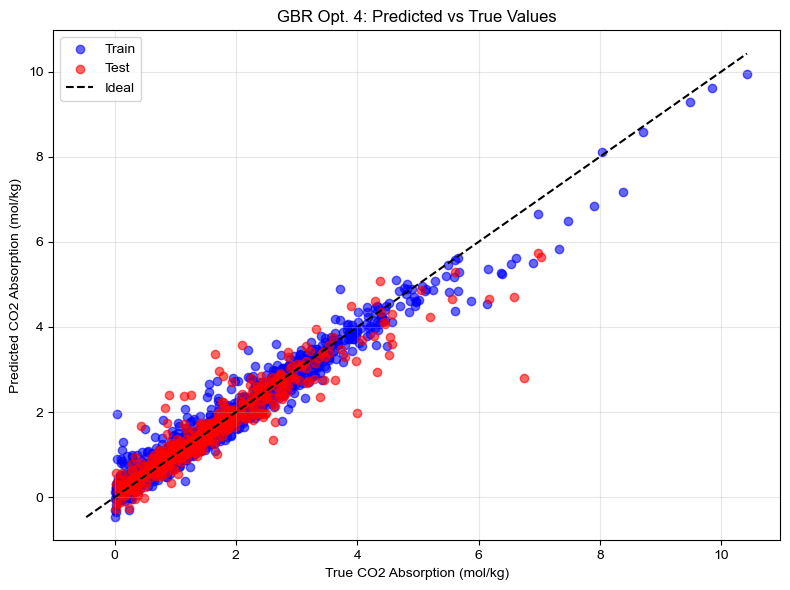


预测可视化图已保存为 'GBR Opt. 4_prediction_plot.png'


In [30]:
# 输出GBR Opt. 4模型的预测结果
print("\n" + "="*80)
print("PREDICTION RESULTS FOR GBR OPT. 4 MODEL")
print("="*80)

# 使用最佳模型进行预测
best_rf = random_search.best_estimator_
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# 创建预测结果DataFrame
train_df = pd.DataFrame({
    'Model': 'GBR Opt. 4',
    'Dataset': 'Train',
    'True_y': y_train,
    'Predicted_y': y_train_pred,
    'Absolute_Error': np.abs(y_train - y_train_pred),
    'Relative_Error_%': np.abs((y_train - y_train_pred) / np.clip(np.abs(y_train), 1e-10, None)) * 100
})

test_df = pd.DataFrame({
    'Model': 'GBR Opt. 4', 
    'Dataset': 'Test',
    'True_y': y_test,
    'Predicted_y': y_test_pred,
    'Absolute_Error': np.abs(y_test - y_test_pred),
    'Relative_Error_%': np.abs((y_test - y_test_pred) / np.clip(np.abs(y_test), 1e-10, None)) * 100
})

# 合并训练集和测试集结果
all_predictions_df = pd.concat([train_df, test_df], ignore_index=True)

# 输出预测结果统计
print(f"\nGBR Opt. 4 预测结果统计:")
print(f"训练集样本数: {len(y_train)}")
print(f"测试集样本数: {len(y_test)}")
print(f"训练集平均绝对误差: {np.mean(np.abs(y_train - y_train_pred)):.4f}")
print(f"测试集平均绝对误差: {np.mean(np.abs(y_test - y_test_pred)):.4f}")
print(f"训练集R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"测试集R²: {r2_score(y_test, y_test_pred):.4f}")

# 输出前20行预测结果
print("\n前20行预测结果:")
print(all_predictions_df.head(20).round(4))

# 按数据集分组统计
print("\n按数据集分组的预测误差统计:")
grouped_stats = all_predictions_df.groupby('Dataset').agg({
    'Absolute_Error': ['mean', 'std', 'min', 'max'],
    'Relative_Error_%': ['mean', 'std', 'min', 'max']
}).round(4)
print(grouped_stats)

# 保存预测结果到CSV文件
import os
csv_filename = 'GBR Opt. 4_predictions.csv'
all_predictions_df.to_csv(csv_filename, index=False)
csv_absolute_path = os.path.abspath(csv_filename)
print(f"\n所有预测结果已保存到 '{csv_absolute_path}'")

# 保存最佳模型
import joblib
best_model_filename = 'best_GBR Opt. 4_model.pkl'
joblib.dump(best_rf, best_model_filename)
model_absolute_path = os.path.abspath(best_model_filename)
print(f"最佳模型已保存为 '{model_absolute_path}'")

# 输出模型详细信息
print("\n" + "="*80)
print("GBR OPT. 4 MODEL DETAILS")
print("="*80)
print(f"最佳参数: {random_search.best_params_}")
print(f"最佳交叉验证分数 (负MSE): {random_search.best_score_:.4f}")
print(f"训练集R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"测试集R²: {r2_score(y_test, y_test_pred):.4f}")

# 可视化预测结果（可选）
import matplotlib.pyplot as plt

# 预测值与真实值对比图
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, label='Train', color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test', color='red')

min_val = min(min(y_train), min(y_test), min(y_train_pred), min(y_test_pred))
max_val = max(max(y_train), max(y_test), max(y_train_pred), max(y_test_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal')

plt.xlabel('True CO2 Absorption (mol/kg)')
plt.ylabel('Predicted CO2 Absorption (mol/kg)')
plt.title('GBR Opt. 4: Predicted vs True Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('GBR Opt. 4_prediction_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n预测可视化图已保存为 'GBR Opt. 4_prediction_plot.png'")

In [31]:
# 为GBR Opt. 4模型输出包含No.和IL信息的预测结果
print("\n" + "="*80)
print("PREDICTION RESULTS FOR GBR OPT. 4 MODEL (WITH No. AND IL)")
print("="*80)

# 获取训练集和测试集的原始索引
train_indices = X_train.index  # 训练集的原始索引
test_indices = X_test.index    # 测试集的原始索引

# 从原始数据中获取对应的No.和IL
train_no = data.loc[train_indices, 'No.'].values
train_il = data.loc[train_indices, 'IL'].values
test_no = data.loc[test_indices, 'No.'].values
test_il = data.loc[test_indices, 'IL'].values

# 使用最佳模型进行预测
best_gbr = random_search.best_estimator_
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

# 创建训练集预测结果DataFrame
train_df = pd.DataFrame({
    'No.': train_no,
    'IL': train_il,
    'Model': 'GBR_Opt_4',  # 使用Model代替Kernel
    'Dataset': 'Train',
    'True_y': y_train.values,
    'Predicted_y': y_train_pred,
    'Absolute_Error': np.abs(y_train.values - y_train_pred),
    'Relative_Error_%': np.abs((y_train.values - y_train_pred) / np.clip(np.abs(y_train.values), 1e-10, None)) * 100
})

# 创建测试集预测结果DataFrame
test_df = pd.DataFrame({
    'No.': test_no,
    'IL': test_il,
    'Model': 'GBR_Opt_4',  # 使用Model代替Kernel
    'Dataset': 'Test',
    'True_y': y_test.values,
    'Predicted_y': y_test_pred,
    'Absolute_Error': np.abs(y_test.values - y_test_pred),
    'Relative_Error_%': np.abs((y_test.values - y_test_pred) / np.clip(np.abs(y_test.values), 1e-10, None)) * 100
})

# 合并训练集和测试集结果
all_predictions_df = pd.concat([train_df, test_df], ignore_index=True)

# 按No.排序
all_predictions_df = all_predictions_df.sort_values(['No.', 'Dataset']).reset_index(drop=True)

# 保存预测结果到CSV文件
csv_filename = 'gbr_opt4_predictions_with_ids.csv'
all_predictions_df.to_csv(csv_filename, index=False)

print(f"\n所有预测结果已保存到 '{csv_filename}'")
print(f"文件包含以下列: {list(all_predictions_df.columns)}")

# 显示示例数据
print("\n示例数据:")
print(all_predictions_df[['No.', 'IL', 'Model', 'Dataset', 'True_y', 'Predicted_y']].head())

# 输出详细的统计信息
print("\n" + "="*80)
print("GBR OPT. 4 模型详细统计信息")
print("="*80)

# 计算评估指标
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"最佳参数: {random_search.best_params_}")
print(f"训练集R²: {train_r2:.4f}")
print(f"测试集R²: {test_r2:.4f}")
print(f"训练集MAE: {train_mae:.4f} mol/kg")
print(f"测试集MAE: {test_mae:.4f} mol/kg")
print(f"训练集RMSE: {train_rmse:.4f} mol/kg")
print(f"测试集RMSE: {test_rmse:.4f} mol/kg")

# 数据完整性验证
print("\n" + "="*80)
print("数据完整性验证")
print("="*80)
print(f"原始数据总条数: {len(data)}")
print(f"预测结果总条数: {len(all_predictions_df)}")
print(f"训练集条数: {len(train_df)}")
print(f"测试集条数: {len(test_df)}")
print(f"No.列唯一值数量: {all_predictions_df['No.'].nunique()}")
print(f"IL列唯一值数量: {all_predictions_df['IL'].nunique()}")

# 检查是否有数据缺失
all_nos = set(data['No.'])
predicted_nos = set(all_predictions_df['No.'])
missing_nos = all_nos - predicted_nos

if missing_nos:
    print(f"警告: 有 {len(missing_nos)} 个No.在预测结果中缺失")
else:
    print("✅ 所有No.都包含在预测结果中")

# 保存最佳模型
import joblib
best_model_filename = 'best_gbr_opt4_model.pkl'
joblib.dump(best_gbr, best_model_filename)
print(f"\n最佳模型已保存为 '{best_model_filename}'")

# 显示文件保存路径
import os
csv_absolute_path = os.path.abspath(csv_filename)
model_absolute_path = os.path.abspath(best_model_filename)
print(f"预测结果文件路径: {csv_absolute_path}")
print(f"模型文件路径: {model_absolute_path}")

print("\n处理完成！GBR Opt. 4模型的预测结果已包含No.和IL信息。")


PREDICTION RESULTS FOR GBR OPT. 4 MODEL (WITH No. AND IL)

所有预测结果已保存到 'gbr_opt4_predictions_with_ids.csv'
文件包含以下列: ['No.', 'IL', 'Model', 'Dataset', 'True_y', 'Predicted_y', 'Absolute_Error', 'Relative_Error_%']

示例数据:
   No.                  IL      Model Dataset  True_y  Predicted_y
0    1  [Bis(mim)C2][Gly]2  GBR_Opt_4   Train  0.8504     0.972757
1    2  [Bis(mim)C2][Gly]2  GBR_Opt_4   Train  1.1442     1.095896
2    3  [Bis(mim)C2][Gly]2  GBR_Opt_4   Train  1.4535     1.660832
3    4  [Bis(mim)C2][Gly]2  GBR_Opt_4   Train  2.3503     2.141728
4    5  [Bis(mim)C2][Gly]2  GBR_Opt_4    Test  2.4895     2.364263

GBR OPT. 4 模型详细统计信息
最佳参数: {'learning_rate': 0.1197248639483835, 'max_depth': 5, 'max_features': 0.837157989396516, 'min_samples_leaf': 3, 'min_samples_split': 15, 'subsample': 0.8511580920506898}
训练集R²: 0.9637
测试集R²: 0.8836
训练集MAE: 0.1456 mol/kg
测试集MAE: 0.2289 mol/kg
训练集RMSE: 0.2306 mol/kg
测试集RMSE: 0.4007 mol/kg

数据完整性验证
原始数据总条数: 2500
预测结果总条数: 2500
训练集条数: 2000
测试集条数: 500
No.

In [ ]:
#代码完